# Imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits import mplot3d
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.tri import Triangulation
from matplotlib import cm
import matplotlib as mlp

# Objective Function

In [2]:
def objective_function(x, y):
    first_term = np.power(x,2) + y -11
    second_term = x + np.power(y,2) - 7
    return np.power(first_term,2)+ np.power(second_term,2)

In [3]:
%matplotlib inline
mlp.rcParams['figure.dpi'] = 200

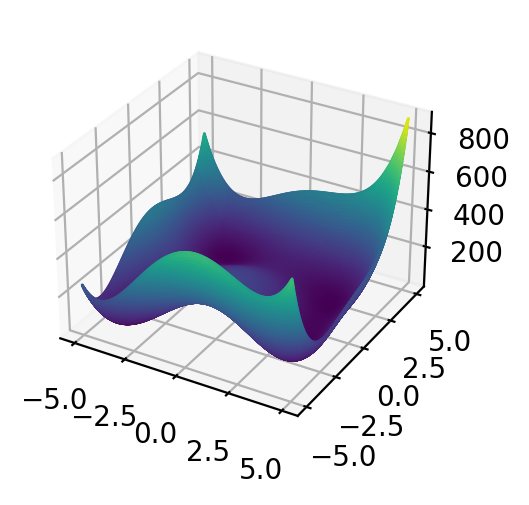

In [4]:
# creating an empty figure for plotting
fig = plt.figure()
ax = fig.add_subplot(1, 2, 1, projection='3d')
 
# creating a range of 200 elements in both
# X and Y
X = np.linspace(-5, 5, 200)
Y = np.linspace(-5, 5, 200)

# Creating a mesh grid of X and Y
X, Y = np.meshgrid(X, Y)
 
# Creating an expression X and Y and
Z = objective_function(X, Y)

norm = plt.Normalize(Z.min(), Z.max())
colors = cm.viridis(norm(Z))
rcount, ccount, _ = colors.shape


surf = ax.plot_surface(X, Y, Z, rcount=rcount, ccount=ccount,
                       facecolors=colors, shade=False)
surf.set_facecolor((0,0,0,0))
plt.show()

# ACO

In [1]:
class Ant:
    def __init__(self,
                 init_location,
                 possible_locations,
                 pheromone_map,
                 calculate_distance,
                 alpha,
                 beta,
                 first_pass=True):
        # params
        self.init_location = init_location
        self.possible_locations = possible_locations
        self.route = []
        self.distance_traveled = 0.0
        self.curr_location = init_location
        self.pheromone_map = pheromone_map
        self.calculate_distance = distance_callback
        self.alpha = alpha
        self.beta = beta
        self.first_pass = first_pass
        
        #append start location to route, before doing random walk
        self.update_route(init_location)
        self.tour_complete = False
        
    def complete_tour(self):
        while self.possible_locations:
            next = self.pick_path()
            self.traverse(self.curr_location, next)
        self.tour_complete = True

    def pick_path(self):
        """
        Select next node from current position.
        """
        # on the first pass (no pheromones); find the next one randomly
        if self.first_pass:
            return np.random.choice(self.possible_locations)

        attractiveness = {}
        sum_total = 0.0
        #for each possible location, find its attractiveness
        for next_ploc in self.possible_locations:
            pheromone_amount = float(self.pheromone_map[self.curr_location][next_ploc])
            distance = float(self.distance_calculation(self.curr_location, next_ploc))
            #tau^alpha * eta^beta
            attractiveness[next_ploc] = np.power(pheromone_amount, self.alpha)*np.power(1/distance, self.beta)
            sum_total += attractiveness[next_ploc]

        #randomly choose the next path
        r = np.random.random()
        cummulative = 0
        for next_ploc in attractiveness:
            weight = (attractiveness[next_ploc] / sum_total)
            if r <= weight + cummulative:
                return possible_next_location
            cummulative += weight

    def traverse(self, start, end):
        """
        Ant goes from start to end and updates lists,
        distance travelled and current location.
        """
        self.update_route(end)
        self.update_distance_traveled(start, end)
        self.curr_location = end

    def update_route(self, new):
        self.route.append(new)
        self.possible_locations.remove(new)

    def update_distance_traveled(self, start, end):
        self.distance_traveled += float(self.calculate_distance(start, end))

    def get_route(self):
        return self.route if self.tour_complete else None

    def get_distance_traveled(self):
        return self.distance_traveled if self.tour_complete else None

In [2]:
class ACO():
    def __init__(self, 
                 n_ants,
                 n_gen):
        pass
    
    def init_ants(self, start):
        """
        on first pass:
            create a number of ant objects
        on subsequent passes, just call __init__ on each to reset them
        by default, all ants start at the first node, 0
        """
        if self.first_pass:
            return [self.ant(start,
                             self.nodes.keys(),
                             self.pheromone_map,
                             self._get_distance,
                             self.alpha,
                             self.beta,
                             first_pass=True) for x in range(self.n_ants)]
        
        for ant in self.ants:
            ant.__init__(start, self.nodes.keys(), self.pheromone_map, self._get_distance, self.alpha, self.beta)
        
    def update_pheromone_map(self):
        """
        1.- Update self.pheromone_map by decaying values contained therein via the ACO algorithm
        2.- Add pheromone_values from all ants from ant_updated_pheromone_map
        """
        for start in range(len(self.pheromone_map)):
            for end in range(len(self.pheromone_map)):
                #decay the pheromone value at this location
                #tau_xy <- (1-rho)*tau_xy (ACO)
                self.pheromone_map[start][end] = (1 - self.pheromone_evaporation_coefficient) * self.pheromone_map[start][end]
                #then add all contributions to this location for each ant that travered it
                #tau_xy <- tau_xy + delta tau_xy_k
                #delta tau_xy_k = Q / L_k
                self.pheromone_map[start][end] += self.ant_updated_pheromone_map[start][end]

    def get_distance(self, start, end):
        assert type(distance) is float
        if not self.distance_matrix[start][end]:
            distance = self.distance_calculation(self.nodes[start], self.nodes[end])
            self.distance_matrix[start][end] = float(distance)
            return distance
        return self.distance_matrix[start][end]

    def init_nodes(self, nodes):
        """
        create a mapping of internal id numbers (0 .. n) to the keys in the nodes passed 
        create a mapping of the id's to the values of nodes
        we use id_to_key to return the route in the node names the caller expects in mainloop()
        """
        id_to_key = dict()
        id_to_values = dict()

        id = 0
        for key in sorted(nodes.keys()):
            id_to_key[id] = key
            id_to_values[id] = nodes[key]
            id += 1

        return id_to_key, id_to_values

    def init_matrix(self, size, value=0.0):
        """
        setup a matrix NxN (where n = size)
        used in both self.distance_matrix and self.pheromone_map
        as they require identical matrixes besides which value to initialize to
        """
        ret = []
        for row in range(size):
            ret.append([float(value) for x in range(size)])
        return ret
    
    def main_loop(self):
        """
        Runs the worker ants, collects their returns and updates the pheromone map with pheromone values
        from workers
            calls:
            _update_pheromones()
            ant.run()
        runs the simulation self.iterations times
        """
        for _ in range(self.iterations):
            #start the multi-threaded ants, calls ant.run() in a new thread
            for ant in self.ants:
                ant.start()
    
            #wait until the ants are finished, before moving on to modifying shared resources
            for ant in self.ants:
                ant.join()

            for ant in self.ants:
                #update ant_updated_pheromone_map with this ant's constribution of pheromones along its route
                self._populate_ant_updated_pheromone_map(ant)

                #if we haven't seen any paths yet, then populate for comparisons later
                if not self.shortest_distance:
                    self.shortest_distance = ant.get_distance_traveled()

                if not self.shortest_path_seen:
                    self.shortest_path_seen = ant.get_route()

                #if we see a shorter path, then save for return
                if ant.get_distance_traveled() < self.shortest_distance:
                    self.shortest_distance = ant.get_distance_traveled()
                    self.shortest_path_seen = ant.get_route()

            #decay current pheromone values and add all pheromone values we saw during traversal (from ant_updated_pheromone_map)
            self._update_pheromone_map()

            #flag that we finished the first pass of the ants traversal
            if self.first_pass:
                self.first_pass = False

            #reset all ants to default for the next iteration
            self._init_ants(self.start)

            #reset ant_updated_pheromone_map to record pheromones for ants on next pass
            self.ant_updated_pheromone_map = self._init_matrix(len(self.nodes), value=0)

        #translate shortest path back into callers node id's
        ret = []
        for id in self.shortest_path_seen:
            ret.append(self.id_to_key[id])

        return ret

In [7]:
aco = ACO(20,20)
aco.init_ants()

TypeError: init_ants() missing 1 required positional argument: 'start'

# --

# Imports

In [9]:
import matplotlib.pyplot as plt
import networkx as nx
import operator
import numpy as np

In [75]:
class Map:
    """
    Useful class to represent the space domain of the problem
    """
    def __init__(self, nodes, distance_matrix):
        self.nodes = nodes
        self.distances = distance_matrix
        self.pheromones = np.ones((len(self.nodes), len(self.nodes)))
        self.local_pheromones = np.zeros((len(self.nodes), len(self.nodes)))
        for i in range(len(nodes)):
            self.pheromones[i][i] = 0

    def update_pheromone_local(self, fro, to, val):
        self.local_pheromones[fro][to] += val

    def update_pheromones_global(self):
        for i in range(0, len(self.nodes)):
            for j in range(0, len(self.nodes)):
                self.pheromones[i][j] = (1 - evaporation_factor) * self.pheromones[i][j] + self.local_pheromones[i][j]
        self.reset_locals()

    def get_pheromone(self, fro, to):
        return self.pheromones[fro][to]

    def get_distance(self, fro, to):
        return self.distances[fro][to]

    def reset_locals(self):
        self.local_pheromones = np.zeros((len(self.nodes), len(self.nodes)))

In [76]:
def draw_graph(graph, i, colorize_solution=False):
    """
    Helper function to draw networkx graphs
    """
    G = nx.Graph()
    G.add_edges_from(graph[0])
    pos = nx.spring_layout(G)
    plt.figure(i)
    if colorize_solution:
        edge_colors = ['purple' if graph[1][e]=="PATH" else 'orange' for e in G.edges]
    else:
        edge_colors ="orange"
    nx.draw(G, pos, edge_color=edge_colors, 
            node_size=100, node_color='lightgreen', alpha=0.59,
            labels={node: node for node in G.nodes()})

    nx.draw_networkx_edge_labels(G, pos, edge_labels=graph[1], font_color='black')
    plt.savefig(f"{save_at}graph{i}.png", dpi=600)
    return G

In [77]:
class Ant:
    """
    Ant class of the ACO algorithm
    """
    def __init__(self, current, unvisited):
        self.current = current
        self.unvisited = unvisited
        self.trail_length = 0

    def travel_next(self):
        prob = np.zeros(len(self.unvisited))
        prob_list = np.zeros(len(self.unvisited))
        fro = ord(self.current) - 65
        sum = 0
        for i in range(0, len(prob)):
            to = ord(self.unvisited[i]) - 65
            prob[i] = pow(country.get_pheromone(fro, to), alpha) * pow((1 / country.get_distance(fro, to)), beta)
            sum += prob[i]

        prob = [prob[i]/sum for i in range(0, len(prob))]
        prob_list = [(prob[i], self.unvisited[i]) for i in range(len(prob))]
        prob_list.sort(key=operator.itemgetter(0), reverse=True)
        probability = np.random.random()
        dest = -1
        for i in range(0, len(prob_list)):
            if probability < prob_list[i][0]:
                self.current = prob_list[i][1]
                dest = ord(self.current) - 65
                self.trail_length += country.get_distance(fro, dest)
                break
            else:
                probability -= prob_list[i][0]
        self.unvisited.remove(self.current)
        if fro != dest:
            country.update_pheromone_local(fro, dest,
                                           country.get_pheromone(fro, dest) + 1 / country.get_distance(
                                               fro, dest))

    def reset_ant(self):
        self.unvisited.clear()
        self.unvisited += country.nodes
        self.unvisited.remove(self.current)

In [78]:
def init():
    # making nodes
    nodes = [chr(i + 65) for i in range(node_count)]
    # deciding distances
    for i in range(0, node_count):
        temp = []
        for j in range(0, i):
            temp.append(distances[j][i])
        for j in range(i, node_count):
            if i == j:
                temp.append(0)
            else:
                temp.append(np.random.uniform(min_distance_limit, max_distance_limit))
        distances.append(temp)
    return nodes

In [79]:
node_count = 6
min_distance_limit = 1
max_distance_limit = 100
iterations = 100
evaporation_factor = 0.5
alpha = 1
beta = 5
save_at = "./"
nodes = []
copy_nodes = []
edges = []
distances = []
edgeLabels = {}
nodes = init()
country = Map(nodes, distances)
print(country.pheromones)
print(country.local_pheromones)
ants = []
copy_nodes += nodes
np.random.shuffle(copy_nodes)

[[0. 1. 1. 1. 1. 1.]
 [1. 0. 1. 1. 1. 1.]
 [1. 1. 0. 1. 1. 1.]
 [1. 1. 1. 0. 1. 1.]
 [1. 1. 1. 1. 0. 1.]
 [1. 1. 1. 1. 1. 0.]]
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]


In [80]:
# Generating Ants
ants = [Ant(copy_nodes[i], list(set(copy_nodes) - set(copy_nodes[i]))) for i in range(len(copy_nodes))]

In [81]:
cur = 0
while cur < iterations:
    for i in range(len(nodes) - 1):
        for ant in ants:
            ant.travel_next()
    best = np.inf
    for ant in ants:
        if best > ant.trail_length:
            best = ant.trail_length
    for ant in ants:
        ant.reset_ant()
    country.update_pheromones_global()
    cur += 1

In [84]:
# Finding shortest paths based on pheromone values
shortest = []
for i in range(node_count):
    max = 0
    for j in range(node_count):
        if country.pheromones[i][j] > country.pheromones[i][max]:
            max = j
    shortest.append((chr(i+65), chr(max+65), country.get_distance(i, max)))

print("Best Traversal Distance = ", best)
print("Shortest Paths A to B(A, B) are = ", shortest)



Best Traversal Distance =  10361.993101973052
Shortest Paths A to B(A, B) are =  [('A', 'D', 34.50238840241264), ('B', 'F', 3.02801903880622), ('C', 'A', 30.56250874638716), ('D', 'A', 34.50238840241264), ('E', 'F', 30.60972286598761), ('F', 'B', 3.02801903880622)]


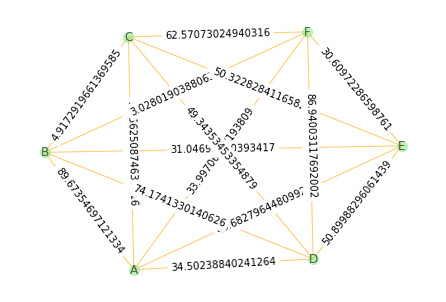

In [87]:
# adding edges and edge labels to distance graph
for i in range(node_count):
    for j in range(i+1, node_count):
        if i != j:
            edges.append([nodes[i], nodes[j]])
            edgeLabels[(nodes[i], nodes[j])] = distances[i][j]
distance_graph = [edges, edgeLabels]
dg = draw_graph(distance_graph, 0)


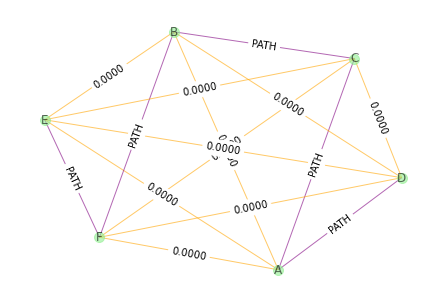

In [86]:
# adding edges and edge labels to pheromone graph
for i in range(node_count):
    for j in range(i+1, node_count):
        if i != j:
            edgeLabels[(nodes[i], nodes[j])] = f"{np.round(country.pheromones[i][j], 2):.4f}" if country.pheromones[i][j] < 100000 else "PATH"
pheromone_graph = [edges, edgeLabels]
pg = draw_graph(pheromone_graph, 1, True)